# Translation with a seq2seq network

In this project we will be teaching a neural network to translate from
French to English.

This is made possible by the simple but powerful idea of the sequence
to sequence network, in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.




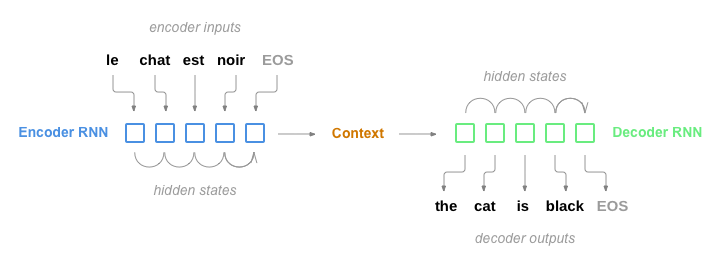



It would also be useful to know about Sequence to Sequence networks and
how they work, so watch the StatQuest [here](//youtu.be/L8HKweZIOmg?si=Xk2AwyMWys0Cwlpt&t=66) first!

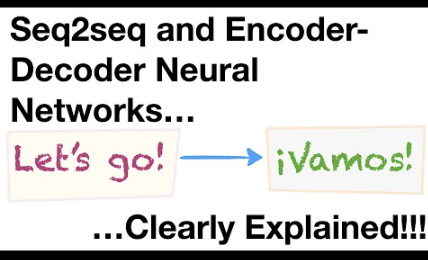



In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading data

The data for this project is a set of many thousands of English to
French translation pairs.

The file `data/eng-fra.txt` is a tab
separated list:

``` {.sh}
I am cold.    J'ai froid.
```





In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data

--2024-12-20 09:37:26--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.38.96, 99.86.38.72, 99.86.38.106, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.38.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.06s   

2024-12-20 09:37:26 (44.5 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.t

Similar to the character encoding used in the character-level RNN
tutorials, we will be representing each word in a language as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word). Compared to the dozens of characters that might exist in a
language, there are many many more words, so the encoding vector is much
larger. We will however cheat a bit and trim the data to only use a few
thousand words per language.

![](https://pytorch.org/tutorials/_static/img/seq-seq-images/word-encoding.png)


We\'ll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called `Lang` which has word → index (`word2index`) and index → word
(`index2word`) dictionaries, as well as a count of each word
`word2count` which will be used to replace rare words later.


In [ ]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.


In [ ]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the `reverse`
flag to reverse the pairs.


In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we\'ll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we\'re filtering to sentences that translate to
the form \"I am\" or \"He is\" etc. (accounting for apostrophes replaced
earlier).


In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-   Read text file and split into lines, split lines into pairs
-   Normalize text, filter by length and content
-   Make word lists from sentences in pairs


In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
['je suis fier de mon fils', 'i m proud of my son']


The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A Sequence to Sequence network, or
seq2seq network, or Encoder Decoder
network, is a model consisting
of two RNNs called the encoder and decoder. The encoder reads an input
sequence and outputs a single vector, and the decoder reads that vector
to produce an output sequence.

![](https://pytorch.org/tutorials/_static/img/seq-seq-images/seq2seq.png)

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence `Je ne suis pas le chat noir` →
`I am not the black cat`. Most of the words in the input sentence have a
direct translation in the output sentence, but are in slightly different
orders, e.g. `chat noir` and `black cat`. Because of the `ne/pas`
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the \"meaning\" of the input sequence into a single
vector --- a single point in some N dimensional space of sentences.


The Encoder
===========

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

![](https://pytorch.org/tutorials/_static/img/seq-seq-images/encoder-network.png)


In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

The Decoder
===========

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.


Simple Decoder
==============

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string `<SOS>`
token, and the first hidden state is the context vector (the encoder\'s
last hidden state).

![](https://pytorch.org/tutorials/_static/img/seq-seq-images/decoder-network.png)


In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

Training
========

Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.


In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

Training the Model
==================

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the `<SOS>` token as its first input, and the last hidden state of the
encoder as its first hidden state.

\"Teacher forcing\" is the concept of using the real target outputs as
each next input, instead of using the decoder\'s guess as the next
input. Using teacher forcing causes it to converge faster but [when the
trained network is exploited, it may exhibit
instability](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf).

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation
-intuitively it has learned to represent the output grammar and can
\"pick up\" the meaning once the teacher tells it the first few words,
but it has not properly learned how to create the sentence from the
translation in the first place.

Because of the freedom PyTorch\'s autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
`teacher_forcing_ratio` up to use more of it.


In [ ]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.


In [ ]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-   Start a timer
-   Initialize optimizers and criterion
-   Create set of training pairs
-   Start empty losses array for plotting

Then we call `train` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.


In [ ]:
from tqdm import tqdm

def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in tqdm(range(1, n_epochs + 1)):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Plotting results
================

Plotting is done with matplotlib, using the array of loss values
`plot_losses` saved while training.


In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder\'s predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder\'s
attention outputs for display later.


In [ ]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, _ = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:


In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we\'ll get
some reasonable results.

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>

<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">

<p>If you run this notebook you can train, interrupt the kernel,evaluate, and continue training later. Comment out the lines where theencoder and decoder are initialized and run <code>trainIters</code> again.</p>

</div>



In [ ]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991


  6%|▋         | 5/80 [00:23<05:44,  4.59s/it]

0m 27s (- 6m 50s) (5 6%) 1.6977


 12%|█▎        | 10/80 [00:44<05:04,  4.36s/it]

0m 48s (- 5m 41s) (10 12%) 0.8887


 19%|█▉        | 15/80 [01:07<04:44,  4.38s/it]

1m 11s (- 5m 8s) (15 18%) 0.5635


 25%|██▌       | 20/80 [01:29<04:23,  4.39s/it]

1m 33s (- 4m 40s) (20 25%) 0.3761


 31%|███▏      | 25/80 [01:51<04:02,  4.41s/it]

1m 55s (- 4m 13s) (25 31%) 0.2601


 38%|███▊      | 30/80 [02:13<03:42,  4.45s/it]

2m 17s (- 3m 48s) (30 37%) 0.1864


 44%|████▍     | 35/80 [02:34<03:11,  4.27s/it]

2m 38s (- 3m 23s) (35 43%) 0.1383


 50%|█████     | 40/80 [02:57<03:01,  4.54s/it]

3m 1s (- 3m 1s) (40 50%) 0.1058


 56%|█████▋    | 45/80 [03:19<02:34,  4.41s/it]

3m 23s (- 2m 38s) (45 56%) 0.0847


 62%|██████▎   | 50/80 [03:41<02:12,  4.43s/it]

3m 45s (- 2m 15s) (50 62%) 0.0691


 69%|██████▉   | 55/80 [04:03<01:51,  4.47s/it]

4m 7s (- 1m 52s) (55 68%) 0.0596


 75%|███████▌  | 60/80 [04:24<01:25,  4.28s/it]

4m 28s (- 1m 29s) (60 75%) 0.0511


 81%|████████▏ | 65/80 [04:46<01:05,  4.34s/it]

4m 50s (- 1m 7s) (65 81%) 0.0464


 88%|████████▊ | 70/80 [05:08<00:43,  4.36s/it]

5m 12s (- 0m 44s) (70 87%) 0.0420


 94%|█████████▍| 75/80 [05:30<00:22,  4.45s/it]

5m 34s (- 0m 22s) (75 93%) 0.0401


100%|██████████| 80/80 [05:52<00:00,  4.40s/it]

5m 56s (- 0m 0s) (80 100%) 0.0357


Set dropout layers to `eval` mode


In [ ]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> ils sont en train de te chercher
= they re looking for you
< they re looking for a little listening to you <EOS>

> tu es chanceuse d avoir un travail
= you re lucky that you have a job
< you re lucky that you have a job <EOS>

> nous allons faire tout ce que nous pouvons
= we re going to do everything we can
< we re going to do everything we can <EOS>

> ils le tiennent secret
= they re keeping it under wraps
< they are doing business with many countries <EOS>

> elles sont toutes contre moi
= they re all against me
< they re all against me all afternoon <EOS>

> nous sommes tous dingues
= we re all crazy
< we re all crazy <EOS>

> je ne suis pas au bureau aujourd hui
= i m not in the office today
< i m not in the office today <EOS>

> je ne le prone pas
= i m not advocating that
< i m not advocating that s <EOS>

> je viens de france
= i m from france
< i am from portugal of his right <EOS>

> tu n es pas morte
= you re not dead
< you re not that smart <EOS>



Exercises
=========

-  Make an evaluation function that lets you input a sentence manually
-  Try with a different dataset
    -   Another language pair: get sentence pairs from [here](//www.manythings.org/anki/)
    -   Human → Machine (e.g. IOT commands)
    -   Chat → Response
    -   Question → Answer
-   Replace the embeddings with pretrained word embeddings such as
    `word2vec` or `GloVe`
-   Try with more layers, more hidden units, and more sentences. Compare
    the training time and results.
-   If you use a translation file where pairs have two of the same
    phrase (`I am test \t I am test`), you can use this as an
    autoencoder. Try this:
    -   Train as an autoencoder
    -   Save only the Encoder network
    -   Train a new Decoder for translation from there


# Sources

Most things shamelessly copied from [PyTorch seq2seq tutorial](//pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)